<a href="https://colab.research.google.com/github/martinosal/wqems_preparedata/blob/main/sen1_training_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import math
from sklearn.utils import shuffle
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import pickle

from sklearn import metrics

from tensorflow.keras import backend as K

def TP(y_true, y_pred, p):
    return np.where(y_pred*y_true>p)[0].shape[0]

def recall_p(y_true, tp, p):
    Positives = y_true.sum()#K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = tp / (Positives+K.epsilon())    
    return recall 

def precision_p(tp, y_pred, p):
    Pred_Positives = np.where(y_pred>p)[0].shape[0]#K.sum(K.round(K.clip(y_pred, 0, 1)))

    precision = tp / (Pred_Positives+K.epsilon())
    return precision 

def f1_m(precision, recall):    
    #precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
    
def recall_m(y_true, y_pred):
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) #treshold 0.5
    Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = TP / (Positives+K.epsilon())    
    return recall 

def precision_m(y_true, y_pred):
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

    precision = TP / (Pred_Positives+K.epsilon())
    return precision 

def custom_f1(y_true, y_pred):    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#def weigthed_accuracy(y_true, y_pred, sample_weights):
#    return K.mean(y_pred)

def plot_history(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  return 


def score_hist(pred,labels):
  plt.hist(pred[np.where(labels==1)],bins=100,label='signal',histtype='step')
  plt.hist(pred[np.where(labels==0)],bins=100,label='bkg',histtype='step')
  plt.yscale('log')
  plt.legend()
  plt.show()

In [3]:
def shuffle_lists(data,y):
  c = list(zip(data, y))
  random.shuffle(c)
  shuff_data, shuff_y = zip(*c)
  return shuff_data, shuff_y

In [4]:
def performance(test_pred_ragged,y):
  ragged_y_flatten = np.concatenate(y).ravel()
  test_pred_ragged_flatten = np.concatenate(test_pred_ragged).ravel()
  print(test_pred_ragged_flatten.shape,ragged_y_flatten.shape)

  #totalone

  recall=recall_m(ragged_y_flatten,test_pred_ragged_flatten)
  precision=precision_m(tf.cast(ragged_y_flatten, tf.float32),tf.cast(test_pred_ragged_flatten, tf.float32))
  f1=custom_f1(tf.cast(ragged_y_flatten, tf.float32),tf.cast(test_pred_ragged_flatten, tf.float32))
  print('recall:',recall)
  print('precision:',precision)
  print('f1:',f1)

  score_hist(test_pred_ragged_flatten,ragged_y_flatten)

  fpr, tpr, thresholds = metrics.roc_curve(ragged_y_flatten, test_pred_ragged_flatten, pos_label=1)
  auc=metrics.auc(fpr, tpr)
  #print(auc)
  plt.figure(figsize=(6,6))
  plt.plot(fpr,tpr,label='AUC: '+str(round(auc*1e3)/1e3))
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.legend()
  plt.show()

  precision_list=list()
  recall_list=list()
  f1_list=list()
  counter=0
  thresh_size=thresholds.shape[0]
  for thresh in thresholds:
    counter+=1
    tp=TP(ragged_y_flatten, test_pred_ragged_flatten, thresh)
    r_t=recall_p(ragged_y_flatten, tp, thresh)
    p_t=precision_p(tp, test_pred_ragged_flatten, thresh)
    f1_t=f1_m(p_t,r_t)
    precision_list.append(p_t)
    recall_list.append(r_t)
    f1_list.append(f1_t)

    precision_np=np.array(precision_list)
    recall_np=np.array(recall_list)
    f1_np=np.array(f1_list)

  plt.figure(figsize=(6,6))
  plt.plot(precision_np,recall_np)
  plt.xlabel('precision')
  plt.ylabel('recall')
  plt.show()

  return f1, precision, recall, auc, fpr, tpr, thresholds

In [11]:
def data_plotter(data,y):
  ch0=list([])
  ch1=list([])
  for idx in np.arange(len(y)):
    for i in np.arange(data[idx].shape[0]):
      ch0.append(data[idx][i][:,0])
      ch1.append(data[idx][i][:,1])
  
  ch0=np.concatenate(ch0).ravel()
  ch1=np.concatenate(ch1).ravel()

  plt.hist(ch0,bins=100,histtype='step',label='ch 0')
  plt.yscale('log')
  plt.legend()
  plt.show()

  plt.hist(ch1,bins=100,histtype='step',label='ch 1')
  plt.yscale('log')
  plt.legend()
  plt.show()
  return #ch0,ch1    


def data_sigbkg_plotter(data,y):
  ch0_sig=list([])
  ch1_sig=list([])
  ch0_bkg=list([])
  ch1_bkg=list([])
  
  for idx in np.arange(len(y)):
    if len(data[idx])>0:    
      ch0_bkg.append(data[idx][np.where(y[idx]==0)[0],:,0].flatten())
      ch1_bkg.append(data[idx][np.where(y[idx]==0)[0],:,1].flatten())
      ch0_sig.append(data[idx][np.where(y[idx]==1)[0],:,0].flatten())
      ch1_sig.append(data[idx][np.where(y[idx]==1)[0],:,1].flatten())
    else:
      break
  ch0_bkg=np.concatenate(ch0_bkg).ravel()
  ch1_bkg=np.concatenate(ch1_bkg).ravel()
  ch0_sig=np.concatenate(ch0_sig).ravel()
  ch1_sig=np.concatenate(ch1_sig).ravel()

  plt.hist(ch0_sig,bins=100,histtype='step',label='ch 0 - flood')
  plt.hist(ch0_bkg,bins=100,histtype='step',label='ch 0 - noflood')
  plt.yscale('log')
  plt.legend()
  plt.show()

  plt.hist(ch1_sig,bins=100,histtype='step',label='ch 1 - flood')
  plt.hist(ch1_bkg,bins=100,histtype='step',label='ch 1 - noflood')
  plt.yscale('log')
  plt.legend()
  plt.show()
  return #ch0,ch1    




In [6]:
def evaluate_model(model,data,y):
  test_pred_ragged=list()
  test_loss_ragged=list()
  test_acc_ragged=list()
  test_auc_ragged=list()
  test_f1_ragged=list()
  test_recall_ragged=list()
  test_precision_ragged=list()

  for k in np.arange(len(selected_y)):
    print('Number of samples:', y[k].shape[0], 'length of samples:', k+3)
    loss,acc,auc,recall,precision,f1=model.evaluate(data[k], y[k])
    #print('evaluation - loss, acc, auc, f1:',loss,acc,auc,f1)
    test_loss_ragged.append(loss)
    test_acc_ragged.append(acc)
    test_auc_ragged.append(auc)
    test_recall_ragged.append(recall)
    test_precision_ragged.append(precision)
    test_f1_ragged.append(f1)
    pred_tmp=model_gauss.predict(data[k])
    test_pred_ragged.append(pred_tmp)
    score_hist(pred_tmp,y[k])

  return test_pred_ragged,test_loss_ragged,test_acc_ragged,test_auc_ragged,test_f1_ragged,test_recall_ragged,test_precision_ragged


In [7]:
class GaussK_channel_module(Model):
    def __init__(self):
        super(GaussK_channel_module, self).__init__()
        self.p0 = tf.Variable(np.random.normal(0.,0.1),name='p0 - l1: bias')
        self.p1 = tf.Variable(np.random.normal(1.,0.1),name='p1 - l1: slope')
        self.p6 = tf.Variable(np.random.normal(0.,0.1),name='p6 - l2: bias')
        self.p7 = tf.Variable(np.random.normal(1.,0.1),name='p7 - l2: slope')
        self.p2 = tf.Variable(np.random.normal(1.,1),name='p2 - idx_mean') #was high mean mode: 3,0.1 - better performance on KD
        self.p3 = tf.Variable(np.random.normal(1.,0.1),name='p3 - idx_scale')

    def DX(self,x):
        return np.array(-1.*(np.roll(x,1)-x))[:,1:]

    def get_idx(self,x):
        x_idx=np.array([])
        x_idx=np.append(x_idx,[np.arange(x.shape[1]) for i in np.arange(x.shape[0])]).reshape(x.shape)
        return x_idx

    def GKernel_arg(self,x_idx):
        arg=-abs(self.p3)*(x_idx-abs(self.p2))**2
        return arg

    def GKernel(self,x,y):
        return x*tf.math.exp(y)

    def Norm(self,x):
        return tf.math.exp(-abs(self.p4)*(x-self.p5)**2)

    def linear_1(self, x):
        f=self.p0 + self.p1*x
        return f

    def linear_2(self, x):
        f=self.p6 + self.p7*x
        return f

    def sum(self, x):
        return tf.reduce_sum(x,1,keepdims=True)


    def call(self, x, **kwargs):

        x_mean = tf.math.reduce_mean(x,1,keepdims=True)
        x_var = tf.math.reduce_variance(x,1,keepdims=True)
        
        x = self.DX(x)
        x = x[:,::-1]

        x = self.linear_1(x)
        x_idx = self.get_idx(x)
        z = self.GKernel_arg(x_idx)
        t = self.GKernel(x,z)
        t = self.sum(t)
        t = self.linear_2(t)

        t = tf.concat([t,x_mean,x_var],1)

        return t


class GaussK_model(Model):
    def __init__(self):
        super(GaussK_model, self).__init__()
        
        self.channel0_GK = GaussK_channel_module()
        self.channel1_GK = GaussK_channel_module()

        self.pre_out_0 = Dense(12, activation='leaky_relu')
        self.pre_out_1 = Dense(24, activation='leaky_relu')
        self.pre_out_2 = Dense(24, activation='leaky_relu')
        self.pre_out_3 = Dense(12, activation='leaky_relu')
        self.pre_out_4 = Dense(6, activation='leaky_relu')
        self.out = Dense(1, activation='sigmoid')

    def call(self, x, **kwargs):

        x_0 = x[:,:,0]
        x_1 = x[:,:,1]

        t_0 = self.channel0_GK.call(x_0)
        t_1 = self.channel1_GK.call(x_1)

        t = tf.concat([t_0,t_1],1)

        t = self.pre_out_0(t)
        t = self.pre_out_1(t)
        t = self.pre_out_2(t)
        t = self.pre_out_3(t)
        t = self.out(t)

        return t

class GaussK_model_v2(Model):
    def __init__(self):
        super(GaussK_model_v2, self).__init__()
        
        self.channel00_GK = GaussK_channel_module()
        self.channel01_GK = GaussK_channel_module()
        self.channel10_GK = GaussK_channel_module()
        self.channel11_GK = GaussK_channel_module()

        self.pre_out_0 = Dense(24, activation='leaky_relu')
        self.pre_out_1 = Dense(48, activation='leaky_relu')
        self.pre_out_2 = Dense(48, activation='leaky_relu')
        self.pre_out_3 = Dense(24, activation='leaky_relu')
        self.pre_out_4 = Dense(12, activation='leaky_relu')
        self.out = Dense(1, activation='sigmoid')

    def call(self, x, **kwargs):

        x_0 = x[:,:,0]
        x_1 = x[:,:,1]

        t_00 = self.channel00_GK.call(x_0)
        t_01 = self.channel01_GK.call(x_1)
        t_10 = self.channel10_GK.call(x_0)
        t_11 = self.channel11_GK.call(x_1)

        t1 = tf.concat([t_00,t_01],1)
        t2 = tf.concat([t_10,t_11],1)
        t  = tf.concat([t1,t2],1)

        t = self.pre_out_0(t)
        t = self.pre_out_1(t)
        t = self.pre_out_2(t)
        t = self.pre_out_3(t)
        t = self.out(t)

        return t

In [8]:
path='/content/drive/MyDrive/WQeMS/data/Sen1Floods11_selected-data/new_data/'

In [9]:
with open(path+'selected_ragged_train_data', 'rb') as sel_data:
  selected_data=pickle.load(sel_data)

with open(path+'selected_ragged_train_y', 'rb') as sel_y:
  selected_y=pickle.load(sel_y)

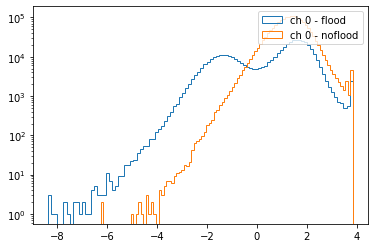

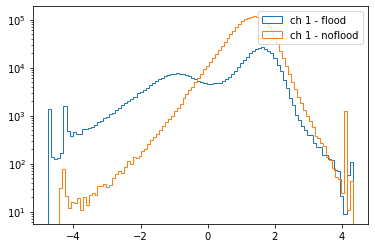

In [12]:
data_sigbkg_plotter(selected_data,selected_y)

In [13]:
with open(path+'ragged_test_data', 'rb') as sel_data:
  test_data=pickle.load(sel_data)

with open(path+'ragged_test_y', 'rb') as sel_y:
  test_y=pickle.load(sel_y)

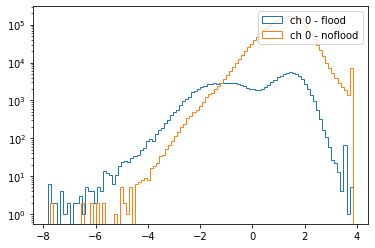

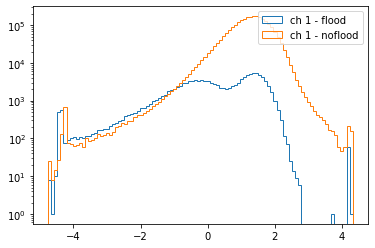

In [14]:
data_sigbkg_plotter(test_data,test_y)

In [15]:
#shuffled_data, shuffled_y = shuffle_lists(selected_data,selected_y)

In [16]:
ragged_class_weights=list([])
for i in np.arange(len(selected_y)):
  #print(ragged_data[i].shape)

  class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(selected_y[i]),
                                                 y=selected_y[i])
  class_weights = dict(zip(np.unique(selected_y[i]), class_weights))
  ragged_class_weights.append(class_weights)

print(ragged_class_weights)

[{0.0: 0.6, 1.0: 3.0}, {0.0: 0.6, 1.0: 3.0}, {0.0: 0.6, 1.0: 3.0}, {0.0: 0.6, 1.0: 3.0}, {0.0: 0.6, 1.0: 3.0}, {0.0: 0.6, 1.0: 3.0}, {0.0: 0.6, 1.0: 3.0}, {0.0: 0.6, 1.0: 3.0}, {0.0: 0.6230127703935366, 1.0: 2.5323093220338984}, {0.0: 0.6, 1.0: 3.0}, {0.0: 2.2877134061013153, 1.0: 0.6398434442270059}, {0.0: 0.6, 1.0: 3.0}, {0.0: 0.6, 1.0: 3.0}, {0.0: 0.6, 1.0: 3.0}, {0.0: 0.6, 1.0: 3.0}, {0.0: 0.6, 1.0: 3.0}, {0.0: 0.6, 1.0: 3.0}, {0.0: 0.6, 1.0: 3.0}, {0.0: 0.6, 1.0: 3.0}, {0.0: 0.6, 1.0: 3.0}, {0.0: 0.6, 1.0: 3.0}, {0.0: 0.6, 1.0: 3.0}, {0.0: 0.6, 1.0: 3.0}]


In [17]:
model_gauss = GaussK_model_v2()

model_gauss.compile(#loss='mean_squared_error',
                    loss='binary_crossentropy',
                    metrics=['accuracy','AUC',recall_m,precision_m,custom_f1], 
                    optimizer='adam',
                    run_eagerly=True)

In [ ]:
#train on more than 1 epoch
N_epochs=5
for epoch in np.arange(N_epochs):
  print('Epoch ',epoch)
  for i in np.arange(len(selected_y)):
    print('lenght ',i+3)
    history = model_gauss.fit(selected_data[i], selected_y[i], 
                              epochs=1,
                              class_weight=ragged_class_weights[i],
                              verbose=1)


Epoch  0
lenght  3
958/958 [==============================] - 61s 62ms/step - loss: 0.0735 - accuracy: 0.9780 - auc: 0.9960 - recall_m: 0.9663 - precision_m: 0.9192 - custom_f1: 0.9363
lenght  4
1604/1604 [==============================] - 99s 62ms/step - loss: 0.0351 - accuracy: 0.9914 - auc: 0.9984 - recall_m: 0.9825 - precision_m: 0.9625 - custom_f1: 0.9694
lenght  5
2184/2184 [==============================] - 129s 59ms/step - loss: 0.0787 - accuracy: 0.9781 - auc: 0.9944 - recall_m: 0.9671 - precision_m: 0.9053 - custom_f1: 0.9281
lenght  6
920/920 [==============================] - 54s 58ms/step - loss: 0.0583 - accuracy: 0.9809 - auc: 0.9974 - recall_m: 0.9729 - precision_m: 0.9102 - custom_f1: 0.9346
lenght  7
114/114 [==============================] - 7s 60ms/step - loss: 0.1277 - accuracy: 0.9565 - auc: 0.9879 - recall_m: 0.9346 - precision_m: 0.8133 - custom_f1: 0.8561
lenght  8
678/678 [==============================] - 40s 59ms/step - loss: 0.0936 - accuracy: 0.9702 - auc:

Number of samples: 9176 length of samples: 3
287/287 [==============================] - 9s 30ms/step - loss: 0.4252 - accuracy: 0.8393 - auc: 0.7345 - recall_m: 0.2169 - precision_m: 0.4993 - custom_f1: 0.2849


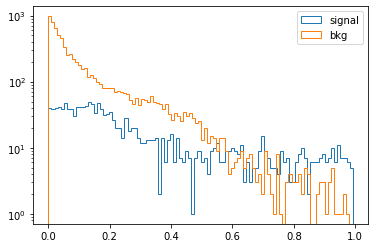

Number of samples: 66691 length of samples: 4
2085/2085 [==============================] - 63s 30ms/step - loss: 0.1864 - accuracy: 0.9409 - auc: 0.9853 - recall_m: 0.9535 - precision_m: 0.7801 - custom_f1: 0.8479


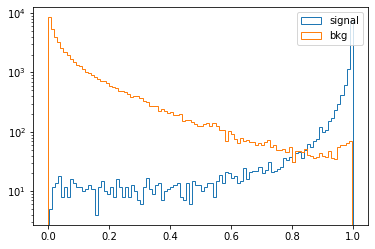

Number of samples: 17701 length of samples: 5
554/554 [==============================] - 17s 31ms/step - loss: 0.2060 - accuracy: 0.9342 - auc: 0.9881 - recall_m: 0.9586 - precision_m: 0.7402 - custom_f1: 0.8243


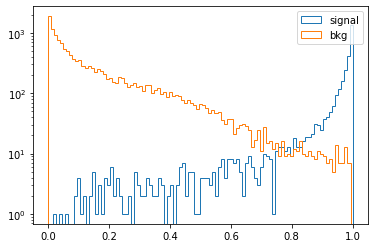

Number of samples: 19188 length of samples: 6
600/600 [==============================] - 18s 30ms/step - loss: 0.1816 - accuracy: 0.9388 - auc: 0.9736 - recall_m: 0.9079 - precision_m: 0.8021 - custom_f1: 0.8392


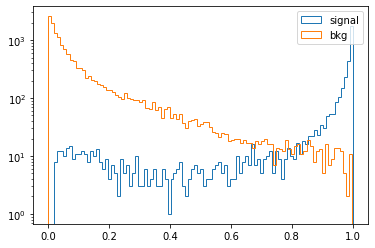

Number of samples: 22975 length of samples: 7
718/718 [==============================] - 24s 34ms/step - loss: 0.1567 - accuracy: 0.9542 - auc: 0.9880 - recall_m: 0.9263 - precision_m: 0.8673 - custom_f1: 0.8867


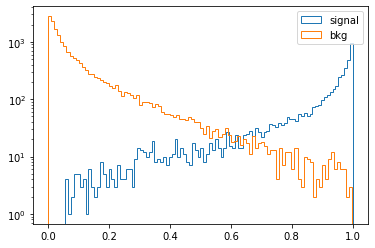

Number of samples: 21560 length of samples: 8
674/674 [==============================] - 21s 32ms/step - loss: 0.0949 - accuracy: 0.9816 - auc: 0.9979 - recall_m: 0.9850 - precision_m: 0.9267 - custom_f1: 0.9506


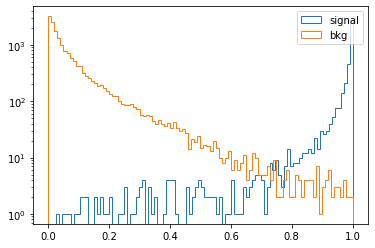

Number of samples: 46735 length of samples: 9
1461/1461 [==============================] - 62s 43ms/step - loss: 0.1155 - accuracy: 0.9712 - auc: 0.9937 - recall_m: 0.9169 - precision_m: 0.9563 - custom_f1: 0.9312


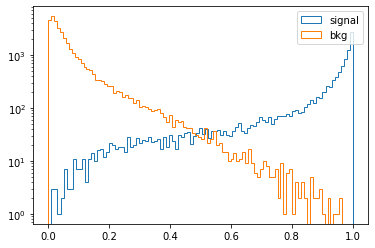

Number of samples: 3011 length of samples: 10
95/95 [==============================] - 6s 62ms/step - loss: 0.1237 - accuracy: 0.9681 - auc: 0.9822 - recall_m: 0.9127 - precision_m: 0.9124 - custom_f1: 0.9032


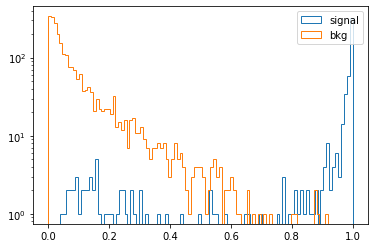

Number of samples: 13820 length of samples: 11
432/432 [==============================] - 14s 32ms/step - loss: 0.0759 - accuracy: 0.9873 - auc: 0.9989 - recall_m: 0.9862 - precision_m: 0.9823 - custom_f1: 0.9836


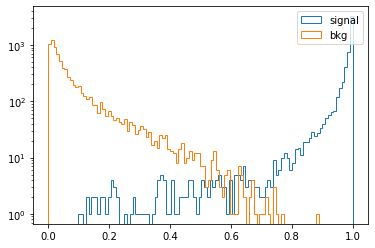

Number of samples: 8371 length of samples: 12
262/262 [==============================] - 8s 31ms/step - loss: 0.2223 - accuracy: 0.8980 - auc: 0.9749 - recall_m: 0.7297 - precision_m: 0.9821 - custom_f1: 0.8294


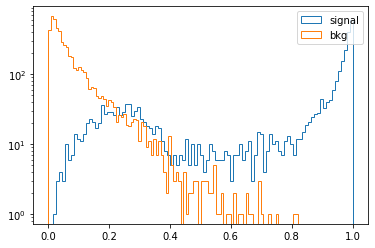

Number of samples: 13169 length of samples: 13
412/412 [==============================] - 13s 31ms/step - loss: 0.1114 - accuracy: 0.9699 - auc: 0.9966 - recall_m: 0.9436 - precision_m: 0.9892 - custom_f1: 0.9645


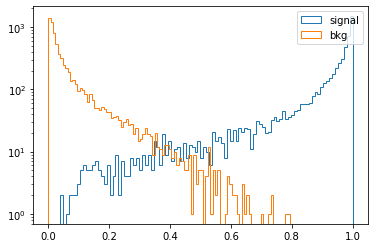

Number of samples: 4796 length of samples: 14
150/150 [==============================] - 5s 32ms/step - loss: 0.1403 - accuracy: 0.9608 - auc: 0.9812 - recall_m: 0.8313 - precision_m: 0.9205 - custom_f1: 0.8611


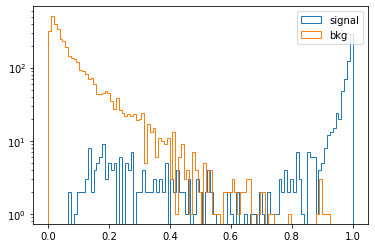

Number of samples: 8354 length of samples: 15
262/262 [==============================] - 9s 36ms/step - loss: 0.0772 - accuracy: 0.9795 - auc: 0.9987 - recall_m: 0.9663 - precision_m: 0.9938 - custom_f1: 0.9793


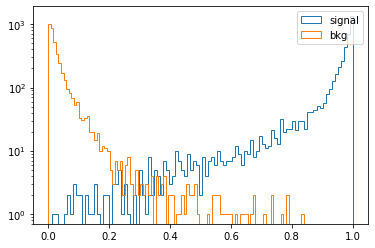

Number of samples: 5661 length of samples: 16
177/177 [==============================] - 8s 45ms/step - loss: 0.1260 - accuracy: 0.9749 - auc: 0.9960 - recall_m: 0.9894 - precision_m: 0.9522 - custom_f1: 0.9693


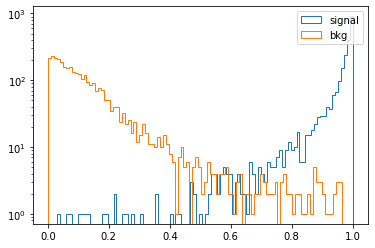

Number of samples: 18 length of samples: 17
1/1 [==============================] - 0s 48ms/step - loss: 0.6237 - accuracy: 0.7778 - auc: 0.4444 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - custom_f1: 0.0000e+00


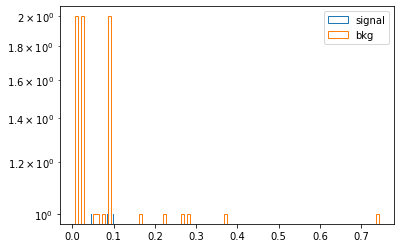

Number of samples: 376 length of samples: 18
12/12 [==============================] - 0s 32ms/step - loss: 0.0689 - accuracy: 1.0000 - auc: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - custom_f1: 1.0000


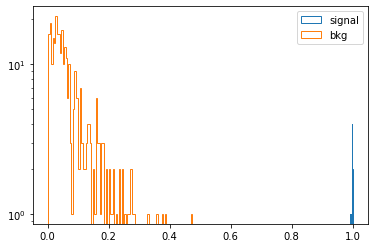

In [38]:
train_pred_ragged,train_loss_ragged,train_acc_ragged,train_auc_ragged,train_f1_ragged,train_recall_ragged,train_precision_ragged=evaluate_model(model_gauss,selected_data,selected_y)

(261602,) (261602,)
recall: tf.Tensor(0.9186473399358821, shape=(), dtype=float64)
precision: tf.Tensor(0.88641363, shape=(), dtype=float32)
f1: tf.Tensor(0.90224266, shape=(), dtype=float32)


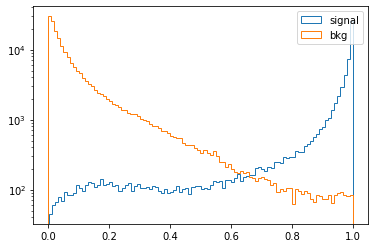

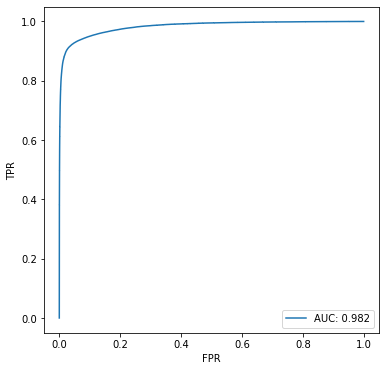

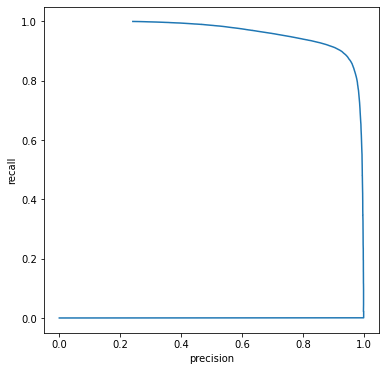

In [88]:
f1, precision, recall, auc, fpr, tpr, thresholds = performance(test_pred_ragged,selected_y)

Number of samples: 124361 length of samples: 3
3887/3887 [==============================] - 117s 30ms/step - loss: 12.2041 - accuracy: 0.4714 - auc: 0.7052 - recall_m: 0.1058 - precision_m: 0.0066 - custom_f1: 0.0123


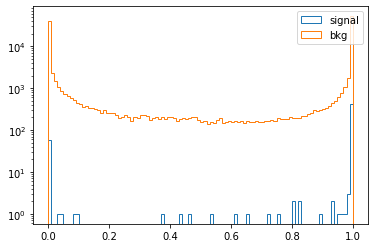

Number of samples: 54925 length of samples: 4
1717/1717 [==============================] - 52s 30ms/step - loss: 20.4763 - accuracy: 0.3108 - auc: 0.6411 - recall_m: 0.1983 - precision_m: 0.0098 - custom_f1: 0.0186


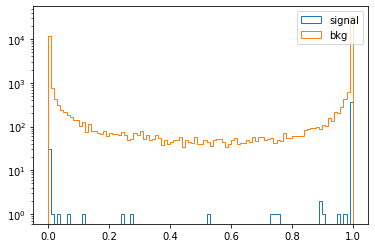

Number of samples: 85672 length of samples: 5
2678/2678 [==============================] - 81s 30ms/step - loss: 14.0346 - accuracy: 0.5142 - auc: 0.6760 - recall_m: 0.9250 - precision_m: 0.3573 - custom_f1: 0.5076


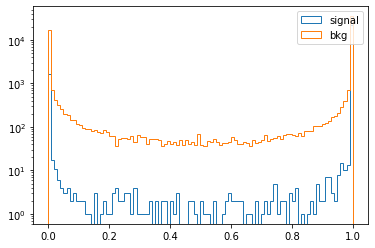

Number of samples: 23290 length of samples: 6
728/728 [==============================] - 23s 31ms/step - loss: 15.1291 - accuracy: 0.4133 - auc: 0.7374 - recall_m: 0.5229 - precision_m: 0.0372 - custom_f1: 0.0687


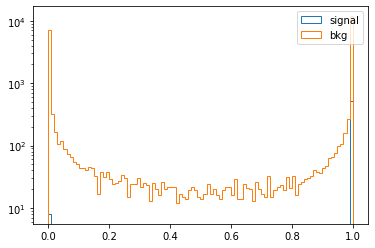

Number of samples: 8126 length of samples: 7
254/254 [==============================] - 8s 31ms/step - loss: 21.3006 - accuracy: 0.3756 - auc: 0.7196 - recall_m: 0.0827 - precision_m: 0.0041 - custom_f1: 0.0079


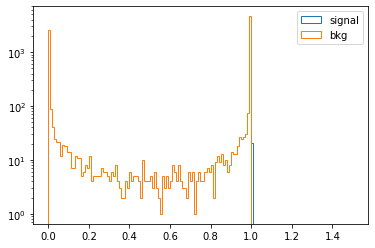

Number of samples: 4573 length of samples: 8
143/143 [==============================] - 4s 31ms/step - loss: 19.4302 - accuracy: 0.2598 - auc: 0.6350 - recall_m: 0.4615 - precision_m: 0.0295 - custom_f1: 0.0549


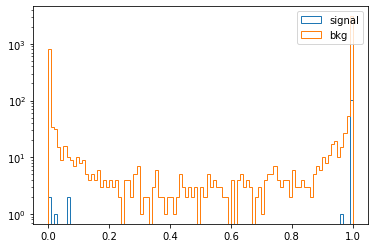

Number of samples: 3525 length of samples: 9
111/111 [==============================] - 3s 31ms/step - loss: 15.9525 - accuracy: 0.2936 - auc: 0.6609 - recall_m: 0.3108 - precision_m: 0.0198 - custom_f1: 0.0350


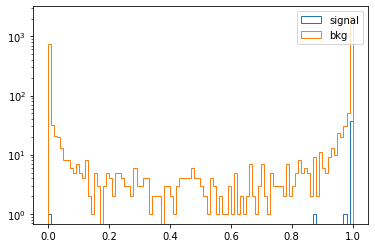

Number of samples: 4971 length of samples: 10
156/156 [==============================] - 5s 31ms/step - loss: 19.4968 - accuracy: 0.1853 - auc: 0.6302 - recall_m: 0.0128 - precision_m: 5.1612e-04 - custom_f1: 9.9206e-04


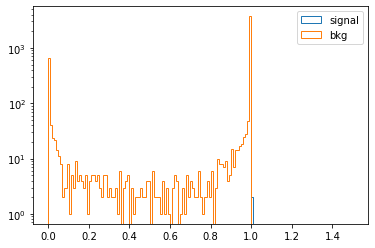

Number of samples: 13203 length of samples: 11
413/413 [==============================] - 14s 34ms/step - loss: 17.7622 - accuracy: 0.2401 - auc: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - custom_f1: 0.0000e+00


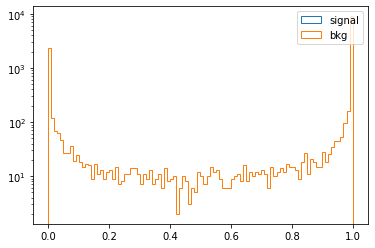

Number of samples: 6513 length of samples: 12
204/204 [==============================] - 6s 31ms/step - loss: 26.2968 - accuracy: 0.2466 - auc: 0.5841 - recall_m: 0.1373 - precision_m: 0.0061 - custom_f1: 0.0117


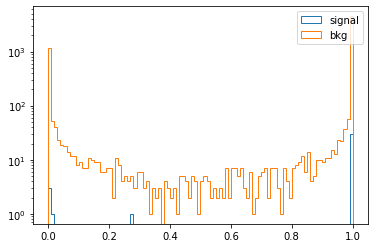

Number of samples: 26802 length of samples: 13
838/838 [==============================] - 26s 31ms/step - loss: 22.4999 - accuracy: 0.1801 - auc: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - custom_f1: 0.0000e+00


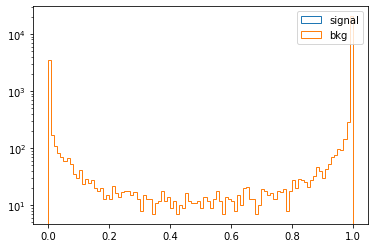

Number of samples: 1807 length of samples: 14
57/57 [==============================] - 2s 32ms/step - loss: 30.9237 - accuracy: 0.1168 - auc: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - custom_f1: 0.0000e+00


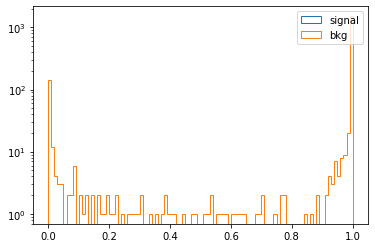

Number of samples: 6605 length of samples: 15
207/207 [==============================] - 6s 31ms/step - loss: 27.1225 - accuracy: 0.2269 - auc: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - custom_f1: 0.0000e+00


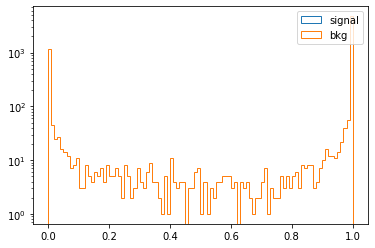

Number of samples: 37801 length of samples: 16
1182/1182 [==============================] - 43s 37ms/step - loss: 29.2532 - accuracy: 0.2245 - auc: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - custom_f1: 0.0000e+00


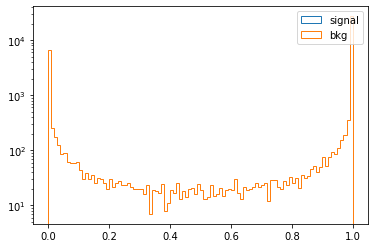

Number of samples: 640 length of samples: 17
20/20 [==============================] - 1s 31ms/step - loss: 15.4014 - accuracy: 0.2703 - auc: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - custom_f1: 0.0000e+00


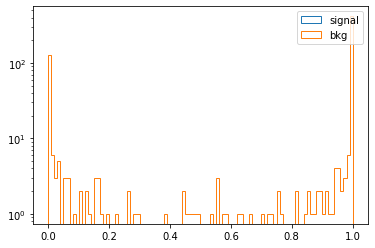

Number of samples: 329 length of samples: 18
11/11 [==============================] - 0s 31ms/step - loss: 17.0223 - accuracy: 0.1976 - auc: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - custom_f1: 0.0000e+00


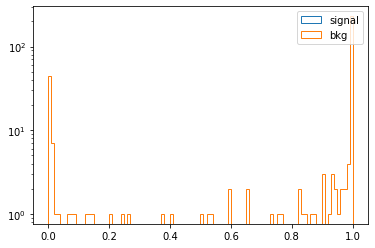

In [92]:
test_pred_ragged,test_loss_ragged,test_acc_ragged,test_auc_ragged,test_f1_ragged,test_recall_ragged,test_precision_ragged=evaluate_model(model_gauss,test_data,test_y)

In [ ]:
f1, precision, recall, auc, fpr, tpr, thresholds = performance(test_pred_ragged,selected_y)